In [27]:
# Import useful libraries for machine learning and visual communication
import matplotlib.pyplot as plt # Used for plotting
import seaborn as sns # Works with matplotlib.pylpot to create nicer plots
sns.set() # Activates the seaborn library
# Makes matplotlib work better in Jupyter Notebooks
%matplotlib inline
import numpy as np # Standard array/matrix library used by many other libraries
import pandas as pd # Useful for reading data from a csv file
import tensorflow as tf # Machine learning library
from tensorflow import keras # Module for creating new models and using pre-trained models
from tensorflow.keras.models import Sequential # Plain stack of layers model
from tensorflow.keras.layers import  *
from tensorflow.keras.optimizers import Adam # Optimizer for training
from tensorflow.keras.applications import VGG19 # Pre-trained model
from tensorflow.keras.utils import to_categorical # Used for creating numerical labels
import os # Used for path referencing
from tensorflow.keras.preprocessing.image import img_to_array # Used to manipluate image data
from tensorflow.keras.preprocessing import image # Reads images
from tqdm import tqdm # Shows progress bar during training
import warnings
warnings.filterwarnings("ignore") # Suppress warnings
from sklearn.metrics import classification_report, confusion_matrix # Used for analyzing the results

In [28]:
# Read in the information associated with the x-rays
meta_data = pd.read_csv(r'C:\Users\adamg\Documents\452.Stuff\Project\input\Chest_xray_Corona_Metadata.csv')
# Replace all 'NaN' with 'unknown'
meta_data.fillna('unknown', inplace=True)
# Show the number of data points in each category
print((meta_data['Label']).value_counts())
print('--------------------------')
print((meta_data['Label_1_Virus_category']).value_counts())

Pnemonia    4334
Normal      1576
Name: Label, dtype: int64
--------------------------
bacteria          2777
unknown           1576
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64


In [29]:
# Remove stress-smoking pnuemonia
meta_data = meta_data[(meta_data['Label'] == 'Normal') | 
                              ((meta_data['Label'] == 'Pnemonia') &
                               (meta_data['Label_1_Virus_category'] != 'Stress-Smoking'))]

# Add a class and target feature
meta_data['Class'] = meta_data.Label_1_Virus_category.apply(lambda x: 'Normal' if x=='unknown' else ('Virus' if x=='Virus' else 'Bacteria'))
meta_data['Target'] = meta_data.Class.apply(lambda x: 0 if x=='Normal' else (1 if x=='Virus' else 2))

# Seperate the training data and the testing data
train_data = meta_data[meta_data['Dataset_type'] == 'TRAIN']
test_data = meta_data[meta_data['Dataset_type'] == 'TEST']

# Keep only the important features
train_data = train_data[['X_ray_image_name', 'Class','Target']]
test_data = test_data[['X_ray_image_name', 'Class','Target']]

# Display the number of images from each class
print('Training Data Numbers')
print(train_data['Class'].value_counts())
print('-------------------------')
print('Testing Data Numbers')
print(test_data['Class'].value_counts())

Training Data Numbers
Bacteria    2535
Virus       1407
Normal      1342
Name: Class, dtype: int64
-------------------------
Testing Data Numbers
Bacteria    242
Normal      234
Virus       148
Name: Class, dtype: int64


In [38]:
def read_img(filename, size, path):
    img = image.load_img(os.path.join(path, filename), target_size=size)
    img = img_to_array(img) / 255
    return img

train_img_dir = r'C:\Users\adamg\Documents\452.Stuff\Project\input\Coronahack-Chest-XRay-Dataset\Coronahack-Chest-XRay-Dataset\train'
test_img_dir = r'C:\Users\adamg\Documents\452.Stuff\Project\input\Coronahack-Chest-XRay-Dataset\Coronahack-Chest-XRay-Dataset\test'

# Extract the training and testing images, then convert them to arrays
train_arrays = [] 
train_data['X_ray_image_name'].apply(lambda x: train_arrays.append(read_img(x, (224,224), train_img_dir)))
test_arrays = []
test_data['X_ray_image_name'].apply(lambda x: test_arrays.append(read_img(x, (224,224), test_img_dir)))

5286    None
5287    None
5288    None
5289    None
5290    None
        ... 
5905    None
5906    None
5907    None
5908    None
5909    None
Name: X_ray_image_name, Length: 624, dtype: object

In [40]:
# Create seperate arrays for the targets
y_train = np.int64(train_data['Target'].values)
y_test = np.int64(test_data['Target'].values)

In [41]:
# Convert to tensors
train_tensors = tf.convert_to_tensor(np.array(train_arrays))
y_train_tensor = tf.convert_to_tensor(to_categorical(y_train))
test_tensors  = tf.convert_to_tensor(np.array(test_arrays))
y_test_tensor = tf.convert_to_tensor(to_categorical(y_test))

# Group tensors
train_dataset = tf.data.Dataset.from_tensor_slices((train_tensors, y_train_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_tensors, y_test_tensor))

In [42]:
BATCH_SIZE = 16
BUFFER = 1000

# Shuffle and create batches
train_batches = train_dataset.shuffle(BUFFER).batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

In [43]:
INPUT_SHAPE = (224,224,3) 

# Get the pretrained model
base_model = tf.keras.applications.VGG19(input_shape= INPUT_SHAPE,include_top=False,weights='imagenet')

# Do not make changes to the base model
base_model.trainable = False

In [51]:
# Create the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))

In [52]:
# Stop training if the model is not learning anymore
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Compile the model
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
# Perform training
model.fit(train_batches, epochs=5, validation_data=test_batches, callbacks=[callbacks])

Epoch 1/4
331/331 [==============================] - 1453s 4s/step - loss: 0.6821 - accuracy: 0.6972 - val_loss: 1.4470 - val_accuracy: 0.4583
Epoch 2/4
331/331 [==============================] - 1417s 4s/step - loss: 0.6535 - accuracy: 0.7385 - val_loss: 1.2927 - val_accuracy: 0.5529
Epoch 3/4
331/331 [==============================] - 1439s 4s/step - loss: 0.5894 - accuracy: 0.7443 - val_loss: 1.4661 - val_accuracy: 0.5705
Epoch 4/4
331/331 [==============================] - 1420s 4s/step - loss: 0.5896 - accuracy: 0.7549 - val_loss: 1.4182 - val_accuracy: 0.5721


In [55]:
# Predict test data
pred = model.predict_classes(np.array(test_arrays))

In [48]:
print(classification_report(test_data['Target'], pred.flatten()))

              precision    recall  f1-score   support

           0       1.00      0.12      0.22       234
           1       0.56      0.53      0.55       148
           2       0.53      1.00      0.69       242

    accuracy                           0.56       624
   macro avg       0.70      0.55      0.49       624
weighted avg       0.72      0.56      0.48       624



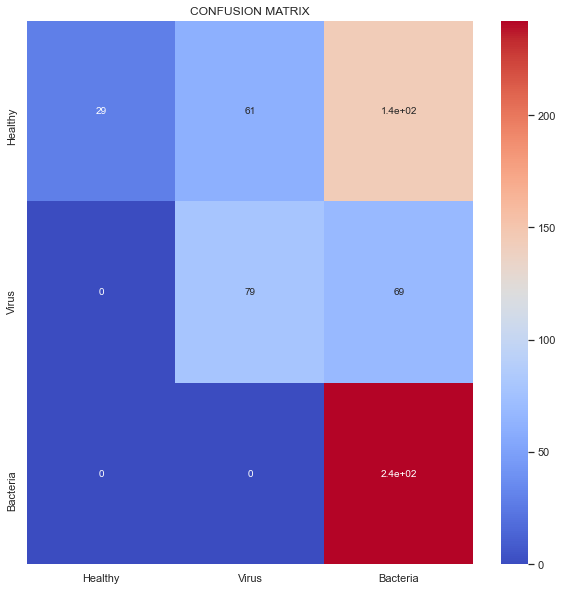

In [50]:
# Create confusion matrix
con_mat = confusion_matrix(test_data['Target'], pred.flatten())
plt.figure(figsize = (10,10))
plt.title('CONFUSION MATRIX')
sns.heatmap(con_mat, cmap='coolwarm',
            yticklabels=['Healthy', 'Virus', 'Bacteria'],
            xticklabels=['Healthy', 'Virus', 'Bacteria'],
            annot=True);